This notebook is to show you how to work with the downscaling target data for the Irrigation Water Demand hackathon challenge. This type of data processing was not covered in the UTCDW Guidebook, so hopefully this notebook will help bridge any gaps in your technical knowledge.

First we'll import the packages we'll need to use.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe
import xclim.sdba as sdba

You are provided with a directory called "Gezira_shapefile" which contains files that describe the Gezira Irrigation Scheme region. We'll use geopandas to open the file, and then plot the domain.

In [2]:
# open shapefile
file_in = "Gezira_shapefile/Gezira.shp"
df_shapefile = gpd.read_file(file_in, crs="epsg:4326")

<Axes: >

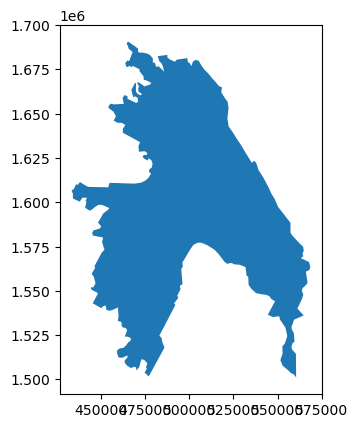

In [3]:
df_shapefile.plot()

Now let's use this shapefile to clip some gridded climate data. We'll start with precipitation data from the 0.25-degree resolution ERA5 reanalysis, as an example. First we'll open the data with xarray.

In [4]:
# open ERA5 data sample
ds_e5_pr_sample = xr.open_dataset("era5_data/precip/e5.precip.daily.1990.nc")

Different climate data products provide precipitation data in different units. The typical unit for reporting daily precipitation is mm/day, so if the data file provides different units, we'll need to convert the units to mm/day. Let's check the attributes of the ERA5 precip data.

In [5]:
ds_e5_pr_sample.tp.attrs

{'units': 'm', 'long_name': 'Total precipitation'}

The units of the ERA5 precip data is metres, so we'll need to multiply it by 1000 to convert to mm.

In [6]:
pr_e5_sample = ds_e5_pr_sample.tp * 1000 # do the unit conversion
pr_e5_sample.attrs['units'] = 'mm/day' # update the unit attributes

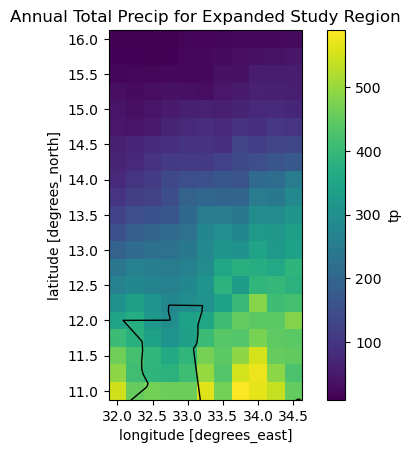

In [7]:
# plot a the annual total, to visualize the data
pr_annual_total = pr_e5_sample.sum('time')
fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.PlateCarree(),transform=ccrs.PlateCarree()))
pr_annual_total.plot.pcolormesh(ax = ax)
ax.coastlines()
ax.set_xticks(pr_annual_total.longitude[::2])
ax.set_yticks(pr_annual_total.latitude[::2])
ax.add_feature(cfeature.BORDERS)
ax.set_title("Annual Total Precip for Expanded Study Region")
plt.show()

As you can see, the data covers a rectangular region, but we're only interested in the Gezira Irrigation Scheme region. We can use a package called rioxarray to make the xarray dataset compatible with the shapefile data. For now, we'll do this only for the annual total, but for your final results you'll want to do it for the whole time-dependent dataset.

In [8]:
# apply rio stuff
pr_annual_total = pr_annual_total.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
pr_annual_total = pr_annual_total.rio.write_crs("epsg:4326")

Now we are ready to "clip" the data, or in other words, mask out everywhere except the region described by the shapefile. The cell below will do this.

In [9]:
clipped = pr_annual_total.rio.clip(df_shapefile.geometry.values, df_shapefile.crs, drop = False, invert = False)

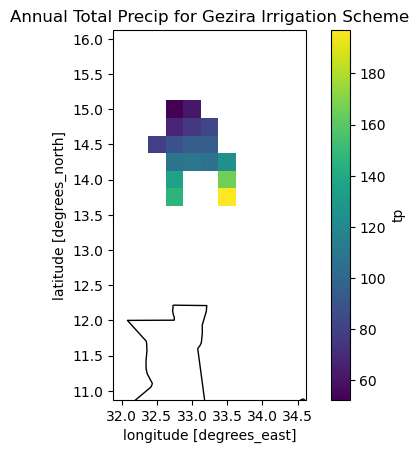

In [10]:
# plot the clipped data
fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.PlateCarree(),transform=ccrs.PlateCarree()))
clipped.plot.pcolormesh(ax = ax)
ax.coastlines()
ax.set_xticks(pr_annual_total.longitude[::2])
ax.set_yticks(pr_annual_total.latitude[::2])
ax.add_feature(cfeature.BORDERS)
ax.set_title("Annual Total Precip for Gezira Irrigation Scheme")
plt.show()

If you're only interested in using the raw ERA5 data as the downscaling target, you can stop here. However, it's clear that the 0.25 degree resolution is coarse compared to the detail of the shapefile. Unfortunately, high-resolution daily observations or reanalysis data for this study region are not available. However, we are providing monthly 4 km resolution data for the study region from the [TerraClimate](https://climatedataguide.ucar.edu/climate-data/terraclimate-global-high-resolution-gridded-temperature-precipitation-and-other-water) dataset. You can combine the monthly information from TerraClimate with the daily information from ERA5 using the "Climate Imprints" (CI) method, which is a lot like the Delta method for bias-adjustment ([Guidebook Ch. 4.2](https://utcdw.physics.utoronto.ca/UTCDW_Guidebook/Chapter4/section4.2_bias_correction_methods.html))

The steps for the CI method is as follows:
1. Re-grid the ERA5 data to the TerraClimate grid using xesmf (this will be demonstrated below).
2. Calculate the monthly total (for precip) or monthly mean (for RH and temperature) from the re-gridded ERA5 data.
3. Re-scale the ERA5 data by either dividing each day by the monthly value (for RH and precip) or subtracting the monthly value (for temperature). We'll call this the ERA5 "anomalies".
4. Add back the monthly information from the TerraClimate data, by either multiplying the ERA5 anomalies by the TerraClimate monthly values (precip and RH) or addition (temperature).
5. Done!

The code below will implement these steps, this time for the whole sample year.


In [11]:
# open the TerraClimate data
ds_pr_TC_sample = xr.open_dataset("TerraClimate_Geriza/precip/TerraClimate.precip.monthly.1990.nc")

# check precip units - looks like they are in mm per month which is what we want, so no unit conversion is needed.
pr_TC_sample = ds_pr_TC_sample.ppt
pr_TC_sample.attrs


{'units': 'mm',
 'description': 'Accumulated Precipitation',
 'long_name': 'precipitation_amount',
 'standard_name': 'precipitation_amount',
 'dimensions': 'lon lat time',
 'grid_mapping': 'crs',
 'coordinate_system': 'WGS84,EPSG:4326',
 '_ChunkSizes': array([   1,  540, 1080], dtype=int32)}

In [12]:
# re-grid ERA5 datas to TerraClimate grid, using bilinear interpolation
# the two datasets have different dimension names, so let's rename the latitdue and longitude dims in the ERA5 data to lat and lon
pr_e5_sample_renamed = pr_e5_sample.rename({'latitude':'lat', 'longitude': 'lon'})

# first create the function that does the re-gridding. We can re-use this for any other data on these two grids.
regridder = xe.Regridder(pr_e5_sample_renamed, pr_TC_sample, "bilinear")

# now do the re-gridding
pr_e5_sample_regridded = regridder(pr_e5_sample_renamed)

In [13]:
# create a new index representing the month and the year, and add it to the ERA5 data. This is not strictly necessary
# for this example, but when you are working with more than 1 year calling ds.groupby('time.month').sum('time') will
# calculate a monthly *climatology*, not monthly totals for each individual month of each individual year.
# Setting up this multi-index means we can calculate the daily anomalies from the monthly aggregates
# using groupby, which is much easier than using the resampling operations.

year_month_idx = pd.MultiIndex.from_arrays([pr_e5_sample_regridded['time.year'].values, pr_e5_sample_regridded['time.month'].values])
pr_e5_sample_regridded.coords['year_month'] = ('time', year_month_idx)

# now calculate the monthly total precip.
pr_e5_monthly = pr_e5_sample_regridded.groupby('year_month').sum('time')

# re-assign units, since the regridder doesn't preserve attributes
pr_e5_monthly.attrs['units'] = 'mm'

In [14]:
# add some random noise to small values to make sure we don't divide by zero
pr_e5_monthly = sdba.processing.jitter_under_thresh(pr_e5_monthly, '0.01 mm')

In [15]:
# divide by the ERA5 monthly totals
pr_e5_anom = pr_e5_sample_regridded.groupby('year_month') / pr_e5_monthly 

In [16]:
# add the year_month index to the TerraClimate data
year_month_idx_TC = pd.MultiIndex.from_arrays([pr_TC_sample['time.year'].values, pr_TC_sample['time.month'].values])
pr_TC_sample.coords['year_month'] = ('time', year_month_idx_TC)

# this does nothing to the data since its already monthly totals, but it will make the main dim of the data year_month
# so we can multiply it by the ERA5 anomalies
pr_TC_sample = pr_TC_sample.groupby('year_month').sum('time')

In [17]:
# for some reason we need to fix the year_month dim or else the groupby below doesn't work
year_month_idx_anom = pd.MultiIndex.from_arrays([pr_e5_anom['time.year'].values, pr_e5_anom['time.month'].values])
pr_e5_anom.coords['year_month'] = ('time', year_month_idx_anom)

# now multiply by the TerraClimate monthly sums
pr_e5_highres = pr_e5_anom.groupby('year_month') * pr_TC_sample

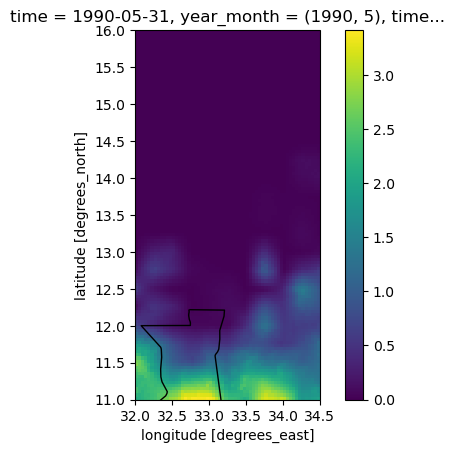

In [18]:
# plot a sample day just to check
fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.PlateCarree(),transform=ccrs.PlateCarree()))
pr_e5_highres.isel(time = 150).plot.pcolormesh(ax = ax)
ax.coastlines()
ax.set_xticks(pr_annual_total.longitude[::2])
ax.set_yticks(pr_annual_total.latitude[::2])
ax.add_feature(cfeature.BORDERS)
plt.show()


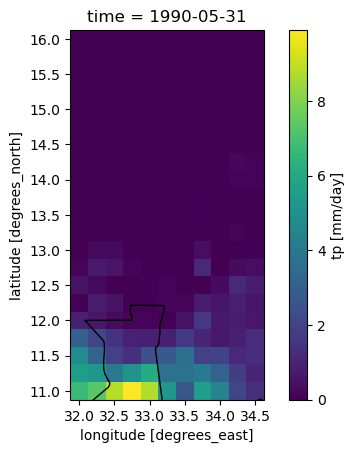

In [19]:
# plot the same day for the raw ERA5 data
fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.PlateCarree(),transform=ccrs.PlateCarree()))
pr_e5_sample.isel(time = 150).plot.pcolormesh(ax = ax)
ax.coastlines()
ax.set_xticks(pr_annual_total.longitude[::2])
ax.set_yticks(pr_annual_total.latitude[::2])
ax.add_feature(cfeature.BORDERS)
plt.show()

Ok, so now we have a high-resolution version of the ERA5 daily precip data, where the fine-scale information comes from the TerraClimate monthly mean data. Let's do the shapefile clipping with this data and plot it. 

In [20]:
# apply rio stuff to the high-res data
pr_e5_highres = pr_e5_highres.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
pr_e5_highres = pr_e5_highres.rio.write_crs("epsg:4326")

# calculate annual total
pr_e5_highres_annual_tot = pr_e5_highres.sum('time')

# clip to the shapefile region
pr_e5_highres_annual_tot_clipped = pr_e5_highres_annual_tot.rio.clip(df_shapefile.geometry.values, df_shapefile.crs, drop = False, invert = False)

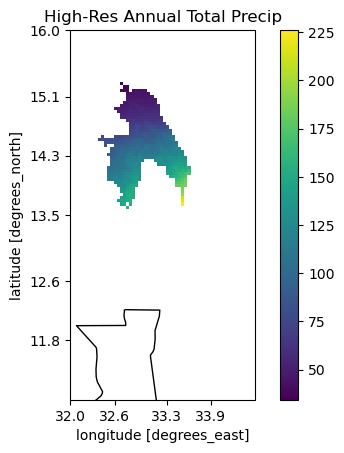

In [21]:
# plot 
fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.PlateCarree(),transform=ccrs.PlateCarree()))
pr_e5_highres_annual_tot_clipped.plot.pcolormesh(ax = ax)
ax.coastlines()
ax.set_xticks(np.around(pr_e5_highres_annual_tot_clipped.lon[::15], 1))
ax.set_yticks(np.around(pr_e5_highres_annual_tot_clipped.lat[::20], 1))
ax.add_feature(cfeature.BORDERS)
ax.set_title("High-Res Annual Total Precip")
plt.show()